In [1]:
import os
import random
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

c:\Users\vipuser\miniconda3\envs\self_register\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### GPU 可用性のテスト

In [2]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### イメージフォルダの処理

次の部分はイメージデータの前処理とデータ増強など

In [3]:
# 数据的前处理和增强
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

データを読み込んだら、トレーニングとテスト用に分割します。

In [4]:
# 自定义数据集拆分函数
def split_dataset(dataset, val_split=0.2):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(val_split * dataset_size)

    # 随机打乱索引
    random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    return train_subset, val_subset


# 加载自定义数据集
data_dir = './dataset_pets'
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
train_dataset, test_dataset = split_dataset(full_dataset)

### HunggingFaceからモデルを導入

In [5]:
# 模型的名字和保存路径
model_name = "google/vit-base-patch16-224"
model_path = "google_vit"

if os.path.exists(model_path):
    model = ViTForImageClassification.from_pretrained(model_path)
    print("Loaded model from google_vit")
else:
    model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True)
    print("Using default pretrained model with custom classifier")

Loaded model from google_vit


導入されたモデルはGPUへ移動してみます。

In [6]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### ラベルをモデルの入力形式に変換

`ViTImageProcessor.from_pretrained` 入力埋め込みの勾配を有効にします。これは、モデルの重みを固定したままアダプターの重みを微調整するのに役立ちます。

In [7]:
# rescaleはいらない、その画像もう正規化されていた。
# processor = ViTImageProcessor.from_pretrained(model_name, do_rescale=False)  # Googleへの接続が必要ですので、エラーが発生した場合は、以下の部分を利用してください。
processor = ViTImageProcessor.from_pretrained(model_name, 
                                                do_rescale=False, 
                                                use_auth_token=False, 
                                                trust_remote_code=False, 
                                                verify=False)

c:\Users\vipuser\miniconda3\envs\self_register\Lib\site-packages\transformers\image_processing_utils.py:192: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


以下の内容はデータの前処理です。

In [8]:
# 数据处理函数
def collate_fn(batch):
    images, labels = zip(*batch)
    images = [img.numpy().transpose((1, 2, 0)) for img in images]
    images = [torch.tensor(img) for img in images]
    encodings = processor(images=images, return_tensors="pt")
    encodings["labels"] = torch.tensor(labels)
    return encodings

### 学習と評価

訓練用パラメータの設定はこちらから

In [9]:
# 参数设置
batch_size = 64
accumulation_steps = 64
epochs = 10

オープンソースのデータセットからデータを読み込み、そのデータをトレーニングとテストの二つの部分に分割します。

In [10]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

オプティマイザーの定義

In [11]:
# 优化器和学习率调度器
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

つぎからはモデルの学習など

In [12]:
# # 模型训练
# model.train()
# for epoch in range(epochs):
#     total_loss = 0
#     optimizer.zero_grad()

#     for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}")):
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss.backward()

#         if (i + 1) % accumulation_steps == 0:
#             optimizer.step()
#             scheduler.step()
#             optimizer.zero_grad()

#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch: {epoch + 1} Loss: {avg_loss:.4f}")

# モデルの学習
model.train()
for epoch in range(epochs): 
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        batch = {k: v.to(device) for k, v in batch.items()} 
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        if (i + 1) % accumulation_steps == 0:  # 64バッチごとに勾配を更新
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch: {epoch + 1} Loss: {avg_loss:.4f}")

Epoch 1:   0%|          | 0/312 [00:00<?, ?it/s]c:\Users\vipuser\miniconda3\envs\self_register\Lib\site-packages\transformers\models\vit\modeling_vit.py:253: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
Epoch 1:  87%|████████▋ | 272/312 [06:53<01:02,  1.56s/it]c:\Users\vipuser\miniconda3\envs\self_register\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1: 100%|██████████| 312/312 [07:51<00:00,  1.51s/it]


Epoch: 1 Loss: 1.5837


Epoch 2: 100%|██████████| 312/312 [06:42<00:00,  1.29s/it]


Epoch: 2 Loss: 0.3823


Epoch 3: 100%|██████████| 312/312 [06:48<00:00,  1.31s/it]


Epoch: 3 Loss: 0.1275


Epoch 4: 100%|██████████| 312/312 [06:44<00:00,  1.30s/it]


Epoch: 4 Loss: 0.0653


Epoch 5: 100%|██████████| 312/312 [06:52<00:00,  1.32s/it]


Epoch: 5 Loss: 0.0385


Epoch 6: 100%|██████████| 312/312 [06:54<00:00,  1.33s/it]


Epoch: 6 Loss: 0.0266


Epoch 7: 100%|██████████| 312/312 [06:49<00:00,  1.31s/it]


Epoch: 7 Loss: 0.0198


Epoch 8: 100%|██████████| 312/312 [06:55<00:00,  1.33s/it]


Epoch: 8 Loss: 0.0148


Epoch 9: 100%|██████████| 312/312 [06:55<00:00,  1.33s/it]


Epoch: 9 Loss: 0.0113


Epoch 10: 100%|██████████| 312/312 [06:56<00:00,  1.34s/it]

Epoch: 10 Loss: 0.0088


訓練が終わったら、モデルの精度を評価します。

Evaluating: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


Test Accuracy: 0.9954
Classification Report:
              precision    recall  f1-score   support

         Cat       0.99      1.00      1.00      2481
         Dog       1.00      0.99      1.00      2510

    accuracy                           1.00      4991
   macro avg       1.00      1.00      1.00      4991
weighted avg       1.00      1.00      1.00      4991



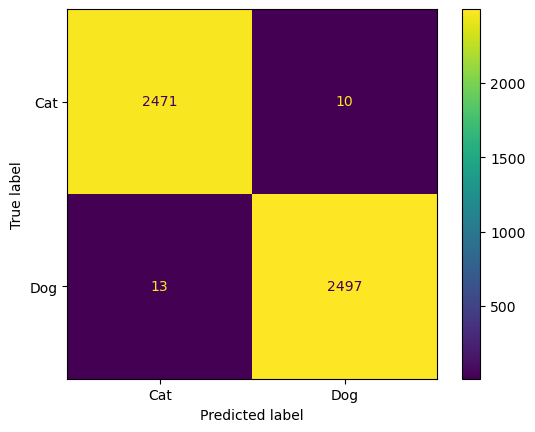

In [13]:
# 模型评估
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=full_dataset.classes)

print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot()
plt.show()

### モデルの保存

In [14]:
# 模型保存
trained_model_path = model_path + '_pets'
model.save_pretrained(trained_model_path)